<a href="https://colab.research.google.com/github/bobyrajtamuli/Customer-Analytics/blob/main/retail_sales_forecasting_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Retail Sales Forecasting & Customer Insights


1. **Forecast sales for Jan–Mar 2024** using a robust time-series workflow.
2. How does customer age and gender influence their purchasing behavior?
3. Are there discernible patterns in sales across different time periods?
4. Which product categories hold the highest appeal among customers?
5. What are the relationships between age, spending, and product preferences?
6. How do customers adapt their shopping habits during seasonal trends?
7. Are there distinct purchasing behaviors based on the number of items bought per transaction?
8. What insights can be gleaned from the distribution of product prices within each category?

In [1]:

# If running in Google Colab, uncomment the next line to install dependencies.
# (You can run this cell as-is in Colab; on local Jupyter you may skip if already installed.)

!pip install prophet python-docx python-pptx openpyxl --quiet


In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from docx import Document
from docx.shared import Inches
from pptx import Presentation
from pptx.util import Inches
from google.colab import files
import io
import os


## 1) Upload your dataset

In [3]:
print("👉 Please upload your dataset (CSV or Excel)...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]

if filename.endswith('.csv'):
    df = pd.read_csv(io.BytesIO(uploaded[filename]))
elif filename.endswith('.xlsx'):
    df = pd.read_excel(io.BytesIO(uploaded[filename]))
else:
    raise ValueError("File must be CSV or Excel")

print("✅ File uploaded and loaded:", filename)
df.head()

👉 Please upload your dataset (CSV or Excel)...


Saving retail_sales_dataset.csv to retail_sales_dataset (5).csv
✅ File uploaded and loaded: retail_sales_dataset (5).csv


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


## 2) Basic Preprocessing


In [4]:
# Try to infer columns - adjust mapping if needed
print("Columns detected:", df.columns)

# Example expected columns (update if your dataset differs)
COLUMN_MAP = {
    "date": "Date",          # transaction date
    "customer_age": "Age",   # customer age
    "customer_gender": "Gender",
    "product_category": "Product Category",
    "Price": "Price per Unit",
    "quantity": "Quantity",
    "transaction_id": "Transaction ID"
}

# Normalize column names
df = df.rename(columns={v: k for k, v in COLUMN_MAP.items() if v in df.columns})

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Add sales = Price * quantity
df['sales'] = df['Price'] * df['quantity']

Columns detected: Index(['Transaction ID', 'Date', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'Price per Unit', 'Total Amount'],
      dtype='object')


# # Step 3: Analysis & Plots

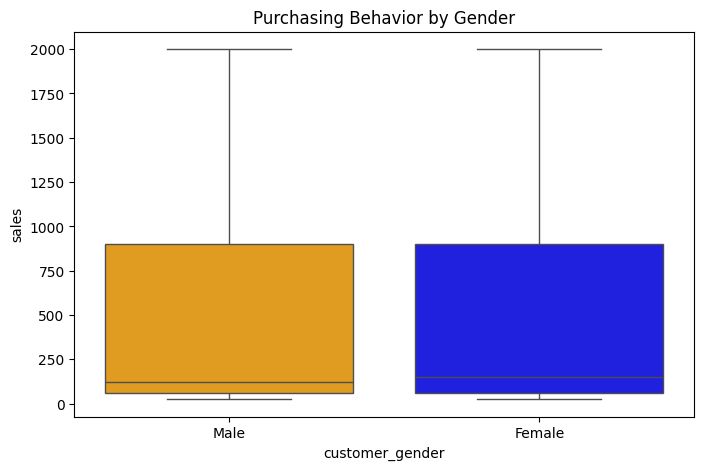

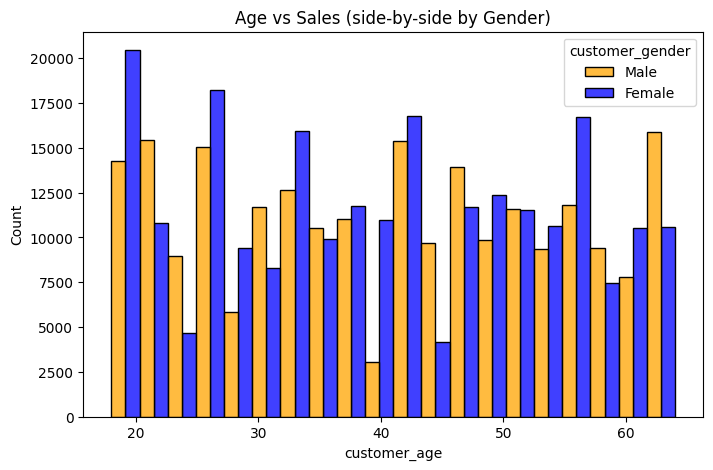

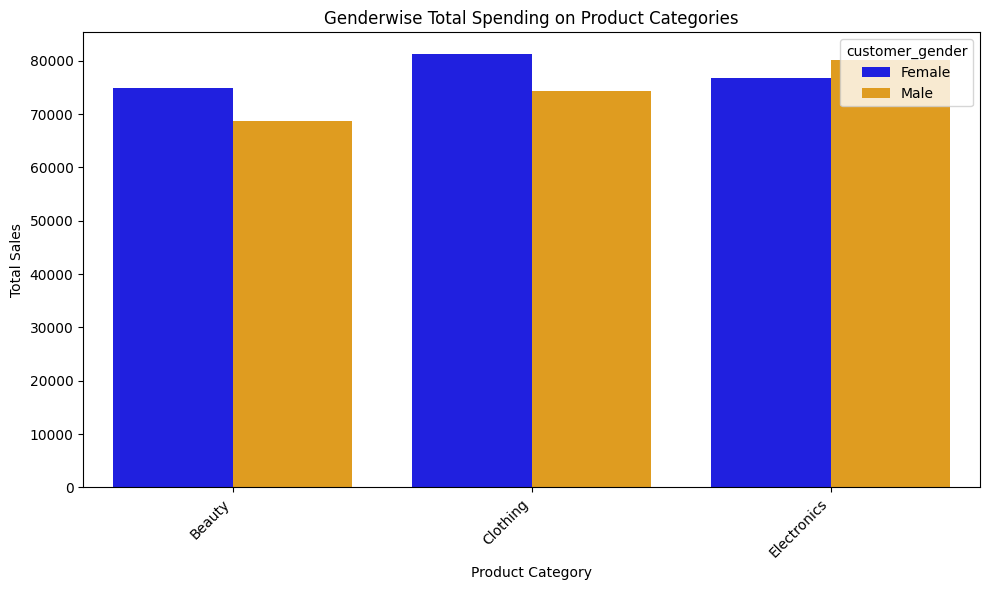

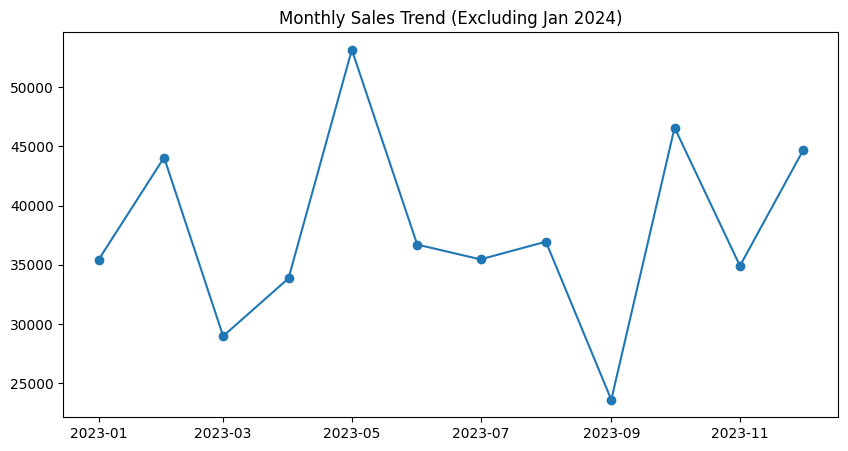

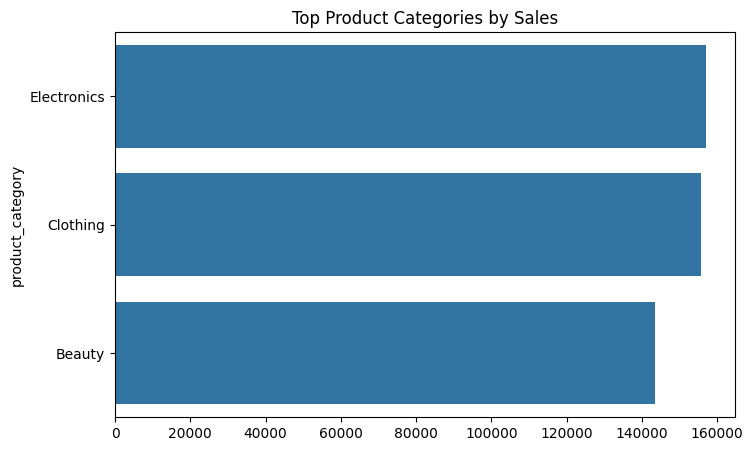

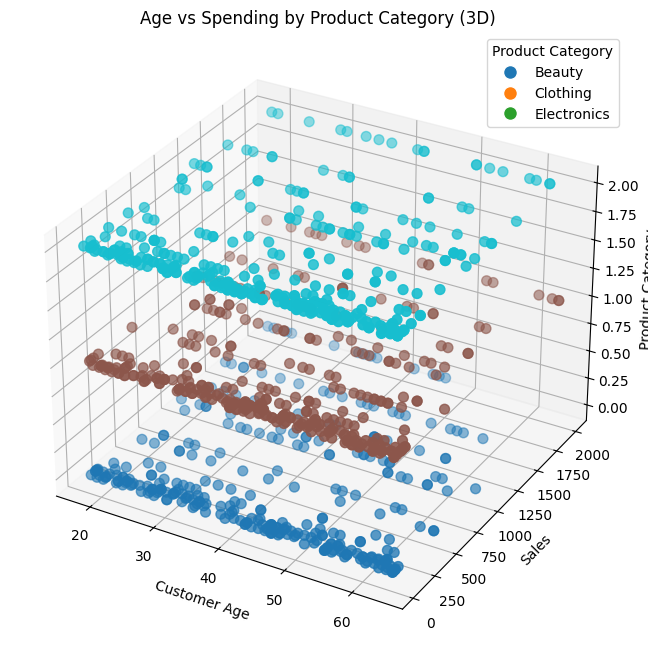

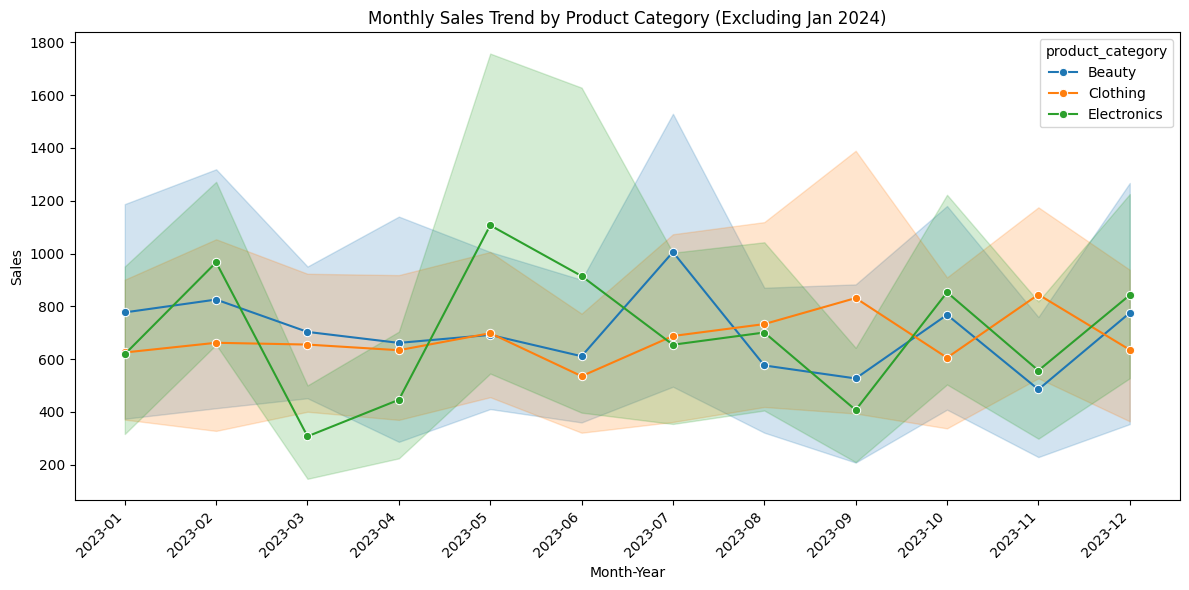

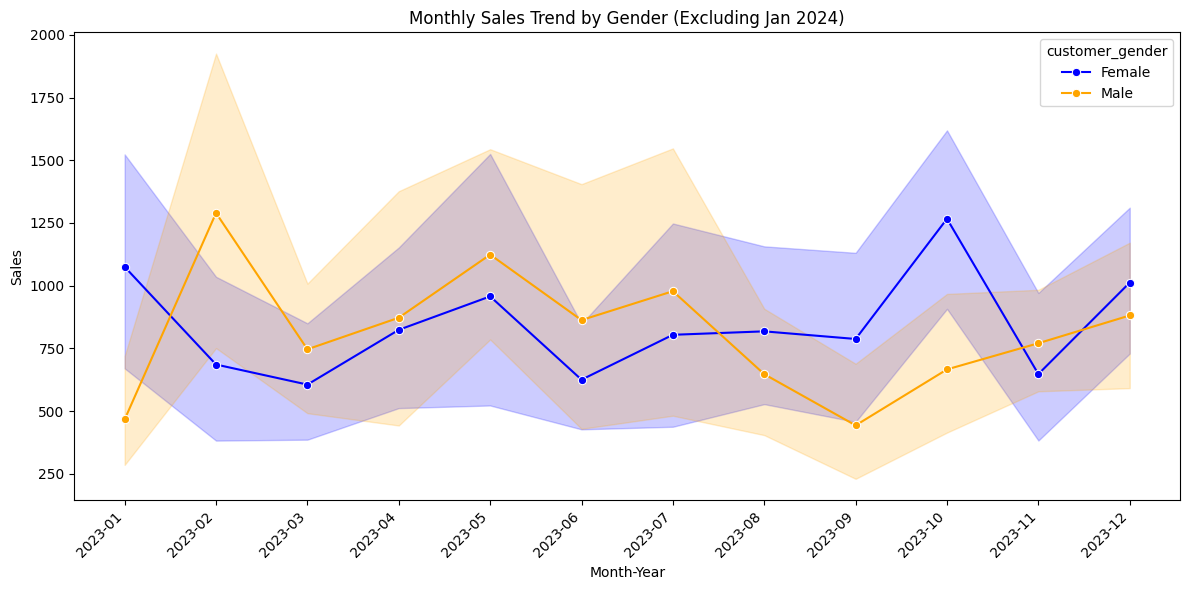

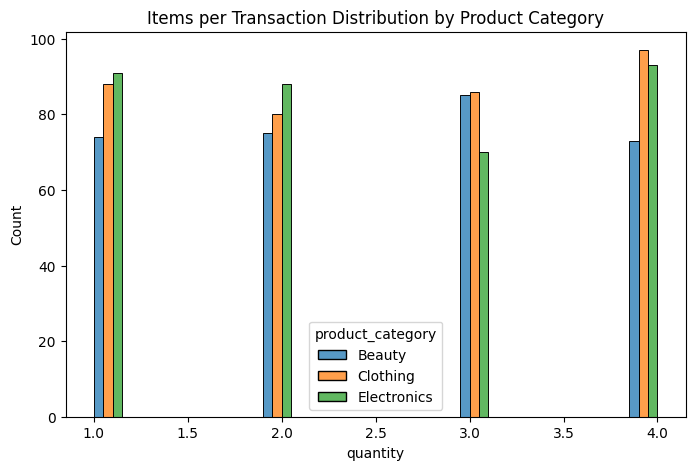

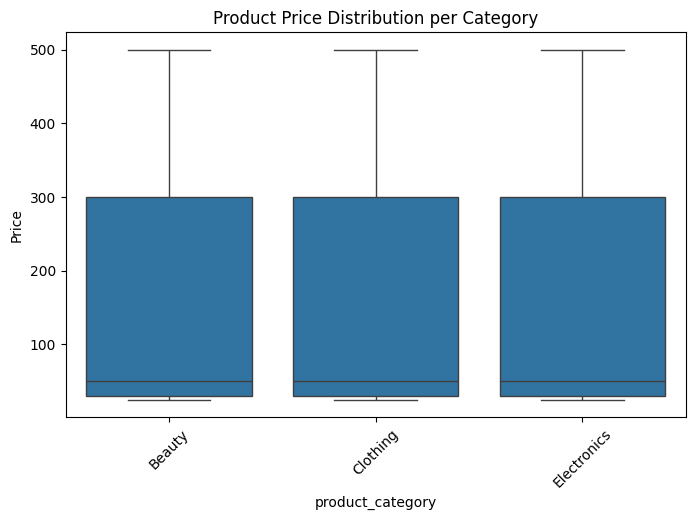

In [32]:
os.makedirs("plots", exist_ok=True)

# Define a custom color palette for gender
gender_colors = {"Male": "orange", "Female": "blue"}

# Q1: Age & Gender vs Purchasing

# Plot total sales by gender
plt.figure(figsize=(8,5))
sns.boxplot(x='customer_gender', y='sales', data=df, hue='customer_gender', palette=gender_colors)
plt.title("Purchasing Behavior by Gender")
plt.show()


# Plot age vs sales side-by-side by gender
plt.figure(figsize=(8,5))
sns.histplot(df, x='customer_age', weights='sales', bins=20, hue='customer_gender', multiple='dodge', palette=gender_colors)
plt.title("Age vs Sales (side-by-side by Gender)")
plt.show()


# Plot genderwise total spending on each category of products
gender_category_sales = df.groupby(['customer_gender', 'product_category'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='product_category', y='sales', hue='customer_gender', data=gender_category_sales, palette=gender_colors)
plt.title("Genderwise Total Spending on Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Q2: Patterns in sales across time
df_time = df.groupby(df['date'].dt.to_period("M"))['sales'].sum().reset_index()
df_time['date'] = df_time['date'].dt.to_timestamp()

# Exclude January 2024 data
df_time_filtered = df_time[df_time['date'].dt.year < 2024].copy()


plt.figure(figsize=(10,5))
plt.plot(df_time_filtered['date'], df_time_filtered['sales'], marker='o')
plt.title("Monthly Sales Trend (Excluding Jan 2024)")
plt.show()


# Q3: Popular product categories
cat_sales = df.groupby('product_category')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=cat_sales.values, y=cat_sales.index)
plt.title("Top Product Categories by Sales")
plt.show()


# Q4: Age, Spending, Preferences (3D Plot)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map product categories to numerical values for coloring
category_map = {category: i for i, category in enumerate(df['product_category'].unique())}
df['category_numerical'] = df['product_category'].map(category_map)


# Use a qualitative colormap for distinct categories
cmap = plt.colormaps.get_cmap('tab10') # Using recommended method


# Scatter plot
scatter = ax.scatter(df['customer_age'], df['sales'], df['category_numerical'], c=df['category_numerical'], cmap=cmap, s=50)

# Labels and title
ax.set_xlabel('Customer Age')
ax.set_ylabel('Sales')
ax.set_zlabel('Product Category')
ax.set_title('Age vs Spending by Product Category (3D)')

# Create a color legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=category,
                              markerfacecolor=cmap(category_map[category]), markersize=10)
                   for category in category_map.keys()]
ax.legend(handles=legend_elements, title="Product Category")


plt.show()


# Q5: Seasonal trends & Monthly Trends

# Product category wise sales trend
category_monthly_trend = df.groupby(['date', 'product_category'])['sales'].sum().reset_index()
category_monthly_trend['month_year'] = category_monthly_trend['date'].dt.to_period('M').astype(str)
# Exclude January 2024 data
category_monthly_trend_filtered = category_monthly_trend[category_monthly_trend['month_year'] != '2024-01'].copy()


plt.figure(figsize=(12, 6))
sns.lineplot(x='month_year', y='sales', hue='product_category', data=category_monthly_trend_filtered, marker='o')
plt.title("Monthly Sales Trend by Product Category (Excluding Jan 2024)")
plt.xlabel("Month-Year")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Monthly sales trend for male and female
gender_monthly_trend = df.groupby(['date', 'customer_gender'])['sales'].sum().reset_index()
gender_monthly_trend['month_year'] = gender_monthly_trend['date'].dt.to_period('M').astype(str)
# Exclude January 2024 data
gender_monthly_trend_filtered = gender_monthly_trend[gender_monthly_trend['month_year'] != '2024-01'].copy()


plt.figure(figsize=(12, 6))
sns.lineplot(x='month_year', y='sales', hue='customer_gender', data=gender_monthly_trend_filtered, marker='o', palette=gender_colors)
plt.title("Monthly Sales Trend by Gender (Excluding Jan 2024)")
plt.xlabel("Month-Year")
plt.ylabel("Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Q6: Items per transaction
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='quantity', hue='product_category', multiple='dodge', bins=20)
plt.title("Items per Transaction Distribution by Product Category")
plt.show()


# Q7: Distribution of product prices
plt.figure(figsize=(8,5))
sns.boxplot(x='product_category', y='Price', data=df)
plt.xticks(rotation=45)
plt.title("Product Price Distribution per Category")
plt.show()

# Step 4: Implement forecasting models - Prophet


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/x33r6erf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/4q78j6mt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13744', 'data', 'file=/tmp/tmpjzadk8_e/x33r6erf.json', 'init=/tmp/tmpjzadk8_e/4q78j6mt.json', 'output', 'file=/tmp/tmpjzadk8_e/prophet_modelu54p2e_b/prophet_model-20250903095055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


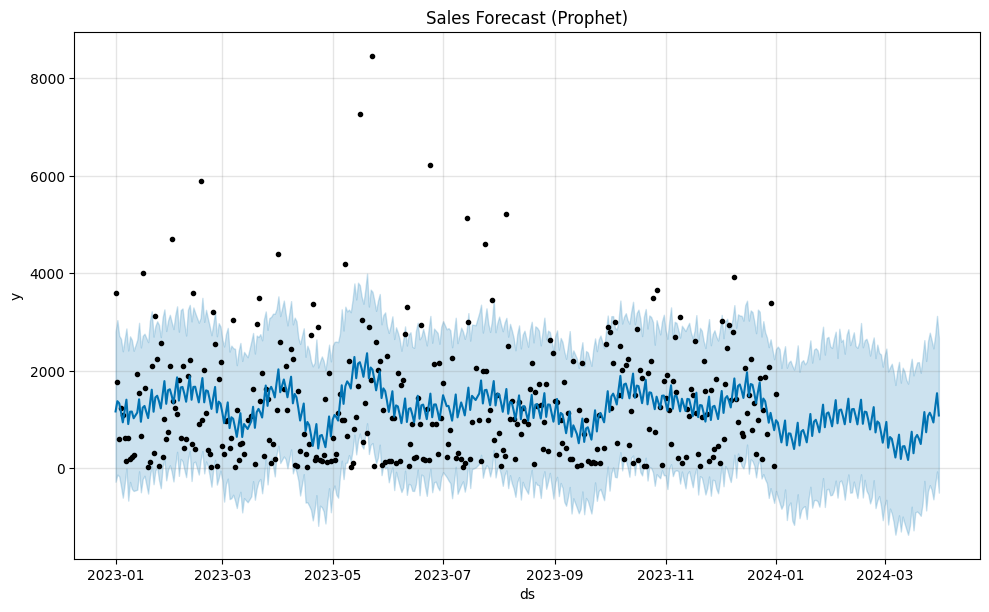

,ds,yhat,yhat_lower,yhat_upper
344,2024-01-01,987.072573,-463.167512,2445.222164
345,2024-01-02,938.697340,-586.587899,2496.555246
346,2024-01-03,748.644636,-712.216482,2443.797193
347,2024-01-04,532.712833,-827.370856,2057.836621
348,2024-01-05,760.702332,-741.872249,2322.855784


In [6]:
forecast_df = df.groupby('date')['sales'].sum().reset_index()
forecast_df = forecast_df.rename(columns={'date': 'ds', 'sales': 'y'})

m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(forecast_df)

future = m.make_future_dataframe(periods=90)  # 3 months
forecast = m.predict(future)

fig1 = m.plot(forecast)
plt.title("Sales Forecast (Prophet)")
plt.show()


# Extract Jan–Mar 2024 forecast
forecast_period = forecast[(forecast['ds'] >= '2024-01-01') & (forecast['ds'] <= '2024-03-31')]
forecast_summary = forecast_period[['ds','yhat','yhat_lower','yhat_upper']]
forecast_summary.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/qbr6rwhn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/ftuoqwu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35897', 'data', 'file=/tmp/tmpjzadk8_e/qbr6rwhn.json', 'init=/tmp/tmpjzadk8_e/ftuoqwu2.json', 'output', 'file=/tmp/tmpjzadk8_e/prophet_modelh0z6xgi6/prophet_model-20250903095057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet Model:
  RMSE: 997.44
  MAPE: 288.09%


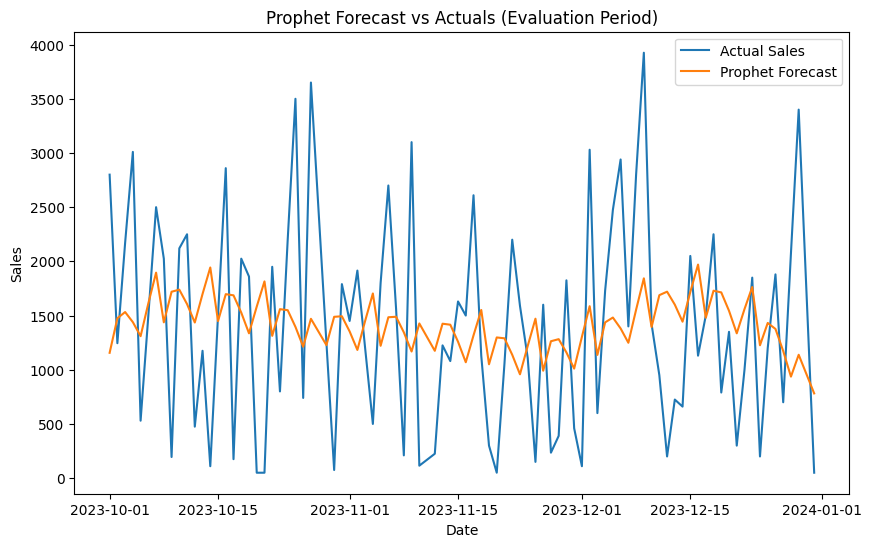

In [7]:
from sklearn.metrics import mean_squared_error

# Redefine the evaluation period to be within the historical data
eval_start_date = '2023-10-01'
eval_end_date = '2023-12-31'

# Re-instantiate and fit Prophet model including history for evaluation
m = Prophet(yearly_seasonality=True, daily_seasonality=False)
m.fit(forecast_df[['ds', 'y']].reset_index(drop=True)) # Fit on the original forecast_df before feature engineering

# Create future dataframe including the historical period for evaluation
future_eval = m.make_future_dataframe(periods=(pd.to_datetime(eval_end_date) - forecast_df['ds'].min()).days + 1)

# Generate forecast including the historical period
forecast_eval = m.predict(future_eval)

# Evaluate Prophet model on the redefined evaluation period
prophet_actual_eval_df = forecast_df[(forecast_df['ds'] >= eval_start_date) & (forecast_df['ds'] <= eval_end_date)].copy()
prophet_predicted_eval_df = forecast_eval[(forecast_eval['ds'] >= eval_start_date) & (forecast_eval['ds'] <= eval_end_date)].copy()


# Ensure both dataframes have the same dates for comparison
merged_prophet_eval = pd.merge(prophet_actual_eval_df, prophet_predicted_eval_df, on='ds', how='inner')


# Calculate Prophet RMSE
rmse_prophet = np.sqrt(mean_squared_error(merged_prophet_eval['y'], merged_prophet_eval['yhat']))

# Calculate Prophet MAPE
# Handle division by zero
prophet_actual_clean = merged_prophet_eval['y'][merged_prophet_eval['y'] != 0]
prophet_predicted_clean = merged_prophet_eval['yhat'][merged_prophet_eval['y'] != 0]
mape_prophet = np.mean(np.abs((prophet_actual_clean - prophet_predicted_clean) / prophet_actual_clean)) * 100

# Print Prophet results
print(f"Prophet Model:")
print(f"  RMSE: {rmse_prophet:.2f}")
print(f"  MAPE: {mape_prophet:.2f}%")

# Plot Prophet forecast against actuals for the evaluation period
plt.figure(figsize=(10, 6))
plt.plot(merged_prophet_eval['ds'], merged_prophet_eval['y'], label='Actual Sales')
plt.plot(merged_prophet_eval['ds'], merged_prophet_eval['yhat'], label='Prophet Forecast')
plt.title('Prophet Forecast vs Actuals (Evaluation Period)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Prepare data for forecasting

### Subtask:
Aggregate sales data to a daily or monthly frequency, creating a time series suitable for forecasting models.


In [8]:
forecast_df = df.groupby('date')['sales'].sum().reset_index()
forecast_df = forecast_df.rename(columns={'date': 'ds', 'sales': 'y'})

## Implement forecasting models - Random Forest


In [9]:
# Create lagged features
for lag in [1, 7, 30]:
    forecast_df[f'y_lag_{lag}'] = forecast_df['y'].shift(lag)

# Create rolling window features
for window in [7, 30]:
    forecast_df[f'y_rolling_mean_{window}'] = forecast_df['y'].rolling(window=window).mean()

# Create day of week feature
forecast_df['day_of_week'] = forecast_df['ds'].dt.dayofweek

# Handle missing values
forecast_df.dropna(inplace=True)

# Split data into training and testing sets
train_end_date = forecast_df['ds'].max() - pd.DateOffset(months=3)
train_df = forecast_df[forecast_df['ds'] <= train_end_date]
test_df = forecast_df[forecast_df['ds'] > train_end_date]

# Define features (X) and target (y)
features = [col for col in forecast_df.columns if col not in ['ds', 'y']]
X_train = train_df[features]
y_train = train_df['y']
X_test = test_df[features]
y_test = test_df['y'] # Keep y_test for evaluation later if needed

# Instantiate and train Random Forest model
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Generate predictions for the test set
predictions_rf = model_rf.predict(X_test)

# Store predictions with dates
forecast_rf_df = pd.DataFrame({'ds': test_df['ds'], 'yhat': predictions_rf})
display(forecast_rf_df.head())

,ds,yhat
256,2023-10-02,1924.35
257,2023-10-03,1843.05
258,2023-10-04,1712.05
259,2023-10-05,1708.90
260,2023-10-06,2565.45



Random Forest Model:
  RMSE: 1127.43
  MAPE: 326.96%


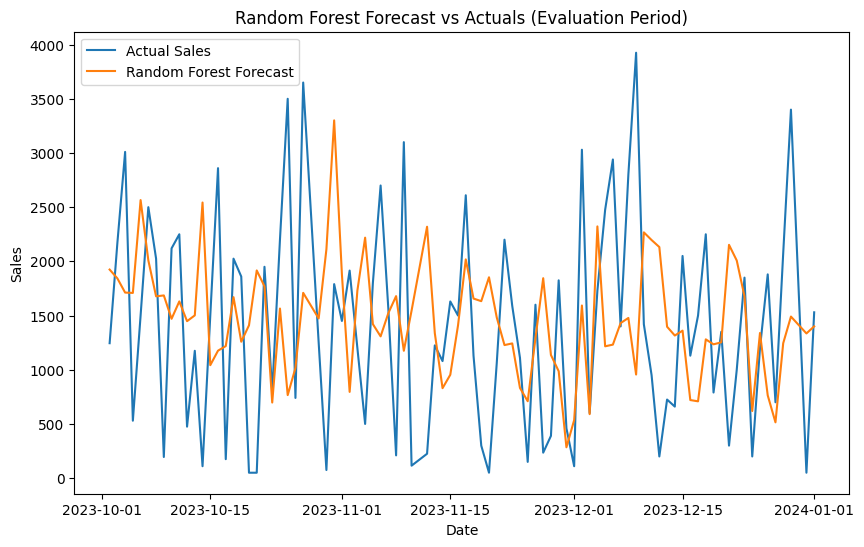

In [10]:
from sklearn.metrics import mean_squared_error

# Evaluate Random Forest model on the test set (which is already the redefined evaluation period)
# Align actual and predicted values for the test period
rf_actual = test_df['y']
rf_predicted = forecast_rf_df['yhat']

# Ensure both series have the same index for comparison
rf_actual = rf_actual.reset_index(drop=True)
rf_predicted = rf_predicted.reset_index(drop=True)

# Create a DataFrame for Random Forest actual and predicted values for plotting
rf_plot_df = pd.DataFrame({'ds': test_df['ds'].reset_index(drop=True), 'Actual Sales': rf_actual, 'Random Forest Forecast': rf_predicted})


# Calculate Random Forest RMSE
rmse_rf = np.sqrt(mean_squared_error(rf_actual, rf_predicted))

# Calculate Random Forest MAPE
# Handle division by zero
rf_actual_clean = rf_actual[rf_actual != 0]
rf_predicted_clean = rf_predicted[rf_actual != 0]
mape_rf = np.mean(np.abs((rf_actual_clean - rf_predicted_clean) / rf_actual_clean)) * 100


# Print Random Forest results
print("\nRandom Forest Model:")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  MAPE: {mape_rf:.2f}%")


# Plot Random Forest forecast against actuals for the evaluation period
plt.figure(figsize=(10, 6))
plt.plot(rf_plot_df['ds'], rf_plot_df['Actual Sales'], label='Actual Sales')
plt.plot(rf_plot_df['ds'], rf_plot_df['Random Forest Forecast'], label='Random Forest Forecast')
plt.title('Random Forest Forecast vs Actuals (Evaluation Period)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## Evaluate model accuracy

### Subtask:
Calculate and compare evaluation metrics (like MAPE and RMSE) for each model's forecast against actual values.


**Reasoning**:
Calculate and print RMSE and MAPE for Prophet and Random Forest models.



In [11]:
from sklearn.metrics import mean_squared_error

# Evaluate Prophet model
# Align actual and predicted values for the forecast period
prophet_actual = forecast_df[(forecast_df['ds'] >= '2024-01-01') & (forecast_df['ds'] <= '2024-03-31')]
prophet_predicted = forecast_period

# Ensure both dataframes have the same dates and align them
merged_prophet = pd.merge(prophet_actual, prophet_predicted, on='ds', how='inner')

# Calculate Prophet RMSE
rmse_prophet = np.sqrt(mean_squared_error(merged_prophet['y'], merged_prophet['yhat']))

# Calculate Prophet MAPE
# Handle division by zero
prophet_actual_clean = merged_prophet['y'][merged_prophet['y'] != 0]
prophet_predicted_clean = merged_prophet['yhat'][merged_prophet['y'] != 0]
mape_prophet = np.mean(np.abs((prophet_actual_clean - prophet_predicted_clean) / prophet_actual_clean)) * 100


# Evaluate Random Forest model
# Align actual and predicted values for the test period
rf_actual = test_df['y']
rf_predicted = forecast_rf_df['yhat']

# Ensure both series have the same index for comparison
rf_actual = rf_actual.reset_index(drop=True)
rf_predicted = rf_predicted.reset_index(drop=True)


# Calculate Random Forest RMSE
rmse_rf = np.sqrt(mean_squared_error(rf_actual, rf_predicted))

# Calculate Random Forest MAPE
# Handle division by zero
rf_actual_clean = rf_actual[rf_actual != 0]
rf_predicted_clean = rf_predicted[rf_actual != 0]
mape_rf = np.mean(np.abs((rf_actual_clean - rf_predicted_clean) / rf_actual_clean)) * 100


# Print results
print(f"Prophet Model:")
print(f"  RMSE: {rmse_prophet:.2f}")
print(f"  MAPE: {mape_prophet:.2f}%")
print("\nRandom Forest Model:")
print(f"  RMSE: {rmse_rf:.2f}")
print(f"  MAPE: {mape_rf:.2f}%")

Prophet Model:
  RMSE: 542.93
  MAPE: 35.49%

Random Forest Model:
  RMSE: 1127.43
  MAPE: 326.96%


## Select best model

### Subtask:
Based on the evaluation metrics, identify the most accurate forecasting model.


**Reasoning**:
Compare the RMSE and MAPE values to determine the best model.



In [12]:
# Determine the best model based on RMSE and MAPE
if rmse_prophet < rmse_rf and mape_prophet < mape_rf:
    best_model = "Prophet"
elif rmse_rf < rmse_prophet and mape_rf < mape_prophet:
    best_model = "Random Forest"
else:
    best_model = "Cannot definitively determine the best model based on both metrics"

print(f"Based on RMSE and MAPE, the best performing model is: {best_model}")

Based on RMSE and MAPE, the best performing model is: Prophet


## Forecast by product category

Apply the best-performing model to generate sales forecasts for each individual product category.


DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/ej5vtbct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/pbu3z0zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


Forecasting for category: Beauty


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53607', 'data', 'file=/tmp/tmpjzadk8_e/ej5vtbct.json', 'init=/tmp/tmpjzadk8_e/pbu3z0zs.json', 'output', 'file=/tmp/tmpjzadk8_e/prophet_model233jgrpj/prophet_model-20250903095059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/s3sbgp1k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/3jihvhw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31620', 'data', 'file=/tmp/tmpjzadk8_e/s3sbgp1k.json', 'init=/tmp/tmpjzadk8_e/3jihvhw6.json', 'output', 'file=/tmp/

Forecasting for category: Clothing


09:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/zw0pt3ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjzadk8_e/wv76uhcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23048', 'data', 'file=/tmp/tmpjzadk8_e/zw0pt3ex.json', 'init=/tmp/tmpjzadk8_e/wv76uhcn.json', 'output', 'file=/tmp/tmpjzadk8_e/prophet_modelns2_x0t_/prophet_model-20250903095100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:51:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:51:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Forecasting for category: Electronics


,Product Category,month,yhat
0,Beauty,2024-01,18361.045566
1,Beauty,2024-02,18037.671532
2,Beauty,2024-03,16986.743207
3,Clothing,2024-01,2100.258102
4,Clothing,2024-02,931.896705
5,Clothing,2024-03,2697.204432
6,Electronics,2024-01,24168.403968
7,Electronics,2024-02,29209.221314
8,Electronics,2024-03,16342.474995


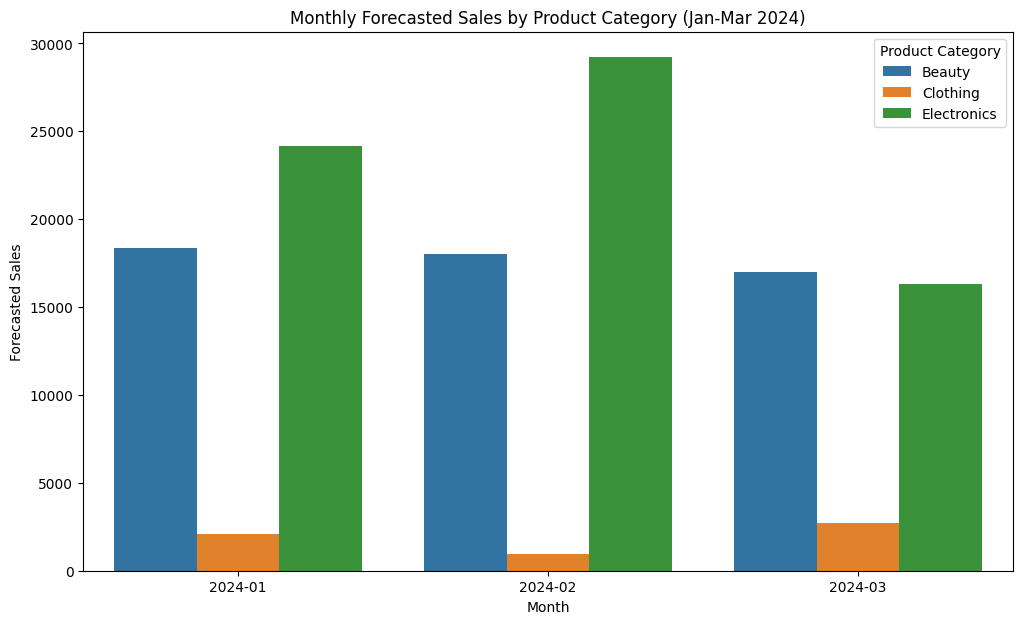

In [13]:
category_forecasts = {}
unique_categories = df['product_category'].unique()

for category in unique_categories:
    print(f"Forecasting for category: {category}")
    # Filter data for the current category
    category_df = df[df['product_category'] == category].copy()

    # Aggregate to daily frequency
    category_daily_sales = category_df.groupby('date')['sales'].sum().reset_index()

    # Prepare data for Prophet
    category_daily_sales = category_daily_sales.rename(columns={'date': 'ds', 'sales': 'y'})

    # Instantiate and fit Prophet model for the category
    m_category = Prophet(yearly_seasonality=True, daily_seasonality=False)
    m_category.fit(category_daily_sales)

    # Create future dataframe for the forecast period (Jan-Mar 2024)
    future_category = m_category.make_future_dataframe(periods=90) # 3 months

    # Generate forecast for the category
    forecast_category = m_category.predict(future_category)

    # Extract Jan–Mar 2024 forecast
    forecast_period_category = forecast_category[(forecast_category['ds'] >= '2024-01-01') & (forecast_category['ds'] <= '2024-03-31')].copy()

    # Store the forecast results
    category_forecasts[category] = forecast_period_category[['ds', 'yhat']]

# Combine all category forecasts into a single DataFrame
category_forecasts_df = pd.concat(category_forecasts.values(), keys=category_forecasts.keys(), names=['Product Category']).reset_index()
# Select the necessary columns instead of dropping by name
category_forecasts_df = category_forecasts_df[['Product Category', 'ds', 'yhat']]

# Aggregate to monthly forecasts for Jan-Mar 2024
category_monthly_forecasts = category_forecasts_df.copy()
category_monthly_forecasts['month'] = category_monthly_forecasts['ds'].dt.to_period('M')
category_monthly_summary = category_monthly_forecasts.groupby(['Product Category', 'month'])['yhat'].sum().reset_index()
category_monthly_summary['month'] = category_monthly_summary['month'].astype(str)


display(category_monthly_summary)

# Plot monthly category-wise forecast as a bar chart
plt.figure(figsize=(12, 7))
sns.barplot(x='month', y='yhat', hue='Product Category', data=category_monthly_summary)
plt.title('Monthly Forecasted Sales by Product Category (Jan-Mar 2024)')
plt.xlabel('Month')
plt.ylabel('Forecasted Sales')
plt.show()

## Present forecast results

### Subtask:
Create a table summarizing the sales forecasts for each product category for the specified period.


**Reasoning**:
Group the category forecasts by product category and sum the forecasted sales to create a summary table.



In [14]:
category_summary = category_forecasts_df.groupby('Product Category')['yhat'].sum().reset_index()
category_summary = category_summary.rename(columns={'yhat': 'Total Forecasted Sales (Jan-Mar 2024)'})
display(category_summary)

,Product Category,Total Forecasted Sales (Jan-Mar 2024)
0,Beauty,53385.460304
1,Clothing,5729.359239
2,Electronics,69720.100277
